# Detecting Emotions in Headlines

### Part I: Exploratory Data Analysis

Author: Kelly Epley


In this notebook, I explore the class distributions and word frequencies in the SemEval 2007 Task 14 [dataset](http://web.eecs.umich.edu/~mihalcea/affectivetext/). 


### Organization

I used a custom function to organize the data into a corpus DataFrame and two sets of targets: emotions and valences. See the file named "get_labeled_dfs" for details.

The emotion target is a set of intensity ratings for six emotion categories on a scale of 0 to 100. The categories are: anger, disgust, fear, joy, sadness, and surprise. The valence target is a single valence rating between -100 and 100. 

I added a "max" label in emotion_df which represents the emotion with the highest intensity rating for each headline. I also added label columns for each emotion with a 1 or 0 indicating whether the emotion is present (i.e. it has a non-zero rating). The labels in valence_df represent negative ratings beween -100 and -15, positive raings between 15 and 100, and low valence/neutral ratings in the middle. 


In [1]:
# import all necessary packages and custom functions, classes
import pandas as pd
import numpy as np

from nltk.util import bigrams

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *
from get_emotion_wordcount import *
from get_pos_neg_wordcount import *

from sklearn.metrics import jaccard_score

In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [3]:
corpus_df.head()

,text
0,Test to predict breast cancer relapse is approved
1,"Two Hussein allies are hanged, Iraqi official ..."
2,Sights and sounds from CES
3,Schuey sees Ferrari unveil new car
4,Closings and cancellations top advice on flu o...


In [4]:
valence_df.head()


,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [5]:
emotion_df.head()


,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Length of Headlines

The headlines in the datasets are all relatively short with an average length of five words and a maximum of ten.

In [6]:
lengths = []
for i in corpus_df['text']:
    lengths.append(len(i.split()))
    
print("The average headline length is {0} words.".format(np.round(sum(lengths)/len(lengths), 2)))
print("The shortest headline length is {0} words.".format(min(lengths)))
print("The longest headline length is {0} words.".format(max(lengths)))

The average headline length is 6.49 words.
The shortest headline length is 2 words.
The longest headline length is 15 words.


## Label Distributions 

The emotion and valence classes are both imbalanced. Of the emotion classes, disgust and anger are much smaller, and joy is much larger. The positive and negative classes are similar sizes, but the neutral class is comparatively small.

Text(0.5, 1.0, 'Number of Headlines per Valence Category')

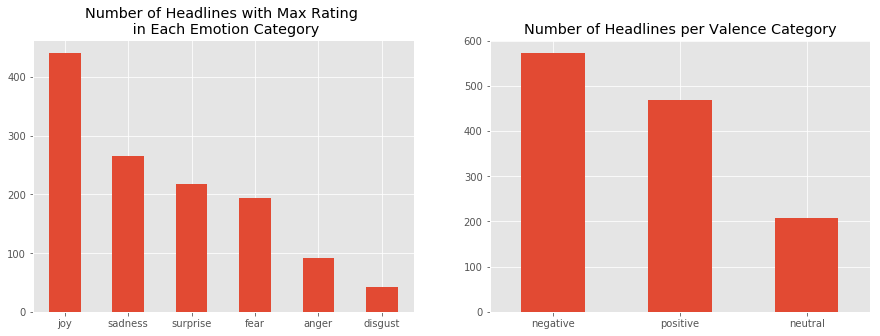

In [17]:
# create bar charts showing headline counts for each category
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
emotion_df['max'].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.title("Number of Headlines with Max Rating \n in Each Emotion Category")

plt.subplot(1,2,2)
valence_df['label'].value_counts().plot(kind='bar')
plt.xticks([0,1,2], ["negative", "positive", "neutral"], rotation='horizontal')
plt.title("Number of Headlines per Valence Category")


Text(0.5, 1.0, 'Number of Emotion Labels Per Headlines')

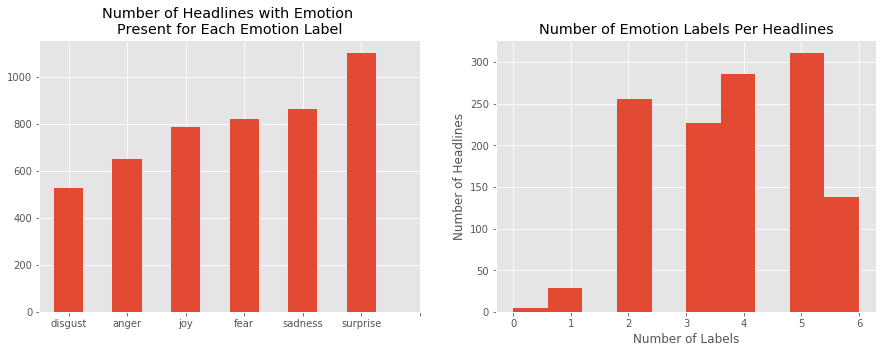

In [15]:
# create bar chart of number of headlines with a non-zero rating for each emotion label
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
emotion_df.iloc[:,7:].sum().sort_values().plot(kind='bar')
plt.xticks([0,1,2,3,4,5,6], ["disgust", "anger", "joy", "fear", "sadness", "surprise"], rotation='horizontal')
plt.title("Number of Headlines with Emotion \nPresent for Each Emotion Label")

# check the number of labels per headline
plt.subplot(1,2,2)
number_of_labels = emotion_df.iloc[:,7] + emotion_df.iloc[:,8] + emotion_df.iloc[:,9] + emotion_df.iloc[:,10] + emotion_df.iloc[:,11] + emotion_df.iloc[:,12]    
number_of_labels.hist()
plt.xlabel("Number of Labels")
plt.ylabel("Number of Headlines")
plt.title('Number of Emotion Labels Per Headlines')

## Label Correlations

As you might expect, there are moderate positive correlations between:

* disgust and anger
* sadness and fear
* fear and anger

There are moderate negative correlations between:

* joy and sadness
* joy and fear
* joy and anger

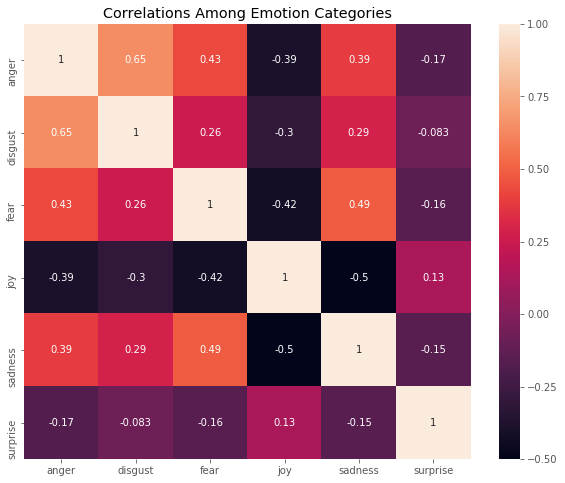

In [13]:
# correlations among emotion categories
plt.figure(figsize=(10,8))
corr = emotion_df.iloc[:,:6].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.title('Correlations Among Emotion Categories')
plt.savefig('emotion_correlations.png')

## Intensity Distributions

There are notable differences in the distribution of intensity ratings among the emotions. 

The valence distributions have means roughly in the middle of their respective ranges.

Text(0.5, 1.0, 'Distributions of Intensity for Each Emotion')

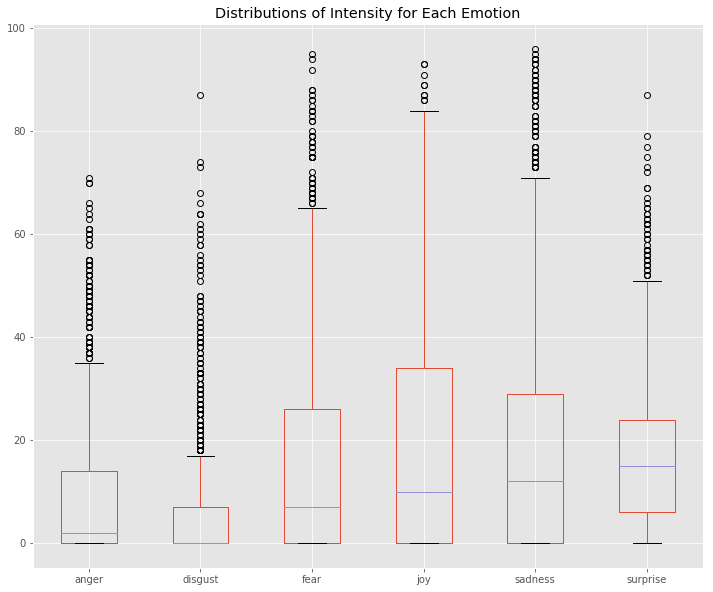

In [14]:
# boxplot showing the disribution of intensity scores for each emotion
plt.figure(figsize=(12,10))
emotion_df.iloc[:,:6].boxplot()
plt.title("Distributions of Intensity for Each Emotion")

Text(0.5, 0.98, 'Distributions of Intensity for Valence Classes')

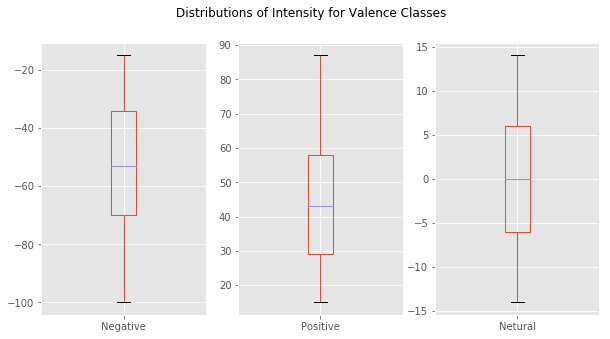

In [15]:
# boxplot showing the disribution of valence scores 
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
valence_df.loc[valence_df['label']==0]['valence'].plot(kind='box')
plt.xticks([1], labels=["Negative"])
plt.subplot(1,3,2)
valence_df.loc[valence_df['label']==1]['valence'].plot(kind='box')
plt.xticks([1], labels=["Positive"])
plt.subplot(1,3,3)
valence_df.loc[valence_df['label']==2]['valence'].plot(kind='box')
plt.xticks([1], labels=["Netural"])
plt.suptitle("Distributions of Intensity for Valence Classes")


In [16]:
# note that there there are a few rows with rating 0 for valence, 
print("Number of rows with 0 valence rating:", len(valence_df.loc[(valence_df.valence==0)]))

Number of rows with 0 valence rating: 15


## Presence of Emotion Words

One obvious strategy for detecting emotions in text is to look for the presence of emotion words such as "happy," "sad," and "afraid." 

To explore this strategy, I used an emotion lexicon from WordNet ([described here](http://wndomains.fbk.eu/wnaffect.html)) which contains lists of words corresponding to the basic emotion categories. I counted instances of emotion words in each headline to see whether the words in the lexicon correspond to the headlines' emotion ratings.

I found a high correspondence between lexicon words and emotion ratings (85%). However, 1140 of the 1250 headlines from the dataset (more than 90%) contain no words from the emotion lexicon, and yet most of these are rated as having detectable emotions and emotional valence.

Accordingly, The lists' author's caution: "All words can potentially convey affective meaning." 

From this we learn that detecting emotions in this dataset will not simply be a matter of finding emotion words.

In [17]:
# get df containing counts of words appearing in emotion word lists
emotion_wordcount = get_emotion_wordcount()

In [18]:
# view headlines containing words from the anger word list
anger_words_df = emotion_wordcount.loc[emotion_wordcount['anger_count']>0]['text']
anger_words_df.head()


216      Israeli woman's tirade spurs PM outrage
267    Bigger, more aggressive rats infesting UK
648                  One search does not fit all
759            'WarioWare,' Wii make perfect fit
987            Roddick, Murray score in San Jose
Name: text, dtype: object

In [19]:
anger_labels = emotion_df.iloc[anger_words_df.index]
print("Headlines with anger words with a non-zero anger rating:", sum(anger_labels['anger_label']), " out of ", len(anger_words_df))


Headlines with anger words with a non-zero anger rating: 2  out of  5


In [20]:
# view headlines containing words from the disgust word list
disgust_words_df = emotion_wordcount.loc[emotion_wordcount['disgust_count']>0]['text']
disgust_words_df.head()


109          US to urge Nato Afghan spring offensive
1219    Teen repellent inventor wins infamous prize 
Name: text, dtype: object

In [21]:
disgust_labels = emotion_df.iloc[disgust_words_df.index]
print("Headlines with digust words with a non-zero disgust rating:", sum(disgust_labels['disgust_label']), " out of ", len(disgust_words_df))


Headlines with digust words with a non-zero disgust rating: 2  out of  2


In [22]:
# view headlines containing words from the fear word list
fear_words_df = emotion_wordcount.loc[emotion_wordcount['fear_count']>0]['text']
fear_words_df.head()

33        TBS to pay $2M fine for ad campaign bomb scare
140                      Firms on alert for letter bombs
234    Memo from Frankfurt: Germany relives 1970s ter...
292    Freed Muslim terror suspect says Britain is "p...
300    In rigorous test, talk therapy works for panic...
Name: text, dtype: object

In [23]:
fear_labels = emotion_df.iloc[fear_words_df.index]
print("Headlines with fear words with a non-zero fear rating:", sum(fear_labels['fear_label']), " out of ", len(fear_words_df))


Headlines with fear words with a non-zero fear rating: 17  out of  17


In [24]:
# view headlines containing words from the joy word list
joy_words_df = emotion_wordcount.loc[emotion_wordcount['joy_count']>0]['text']
joy_words_df.head()


0     Test to predict breast cancer relapse is approved
16                    Asian nations urge Myanmar reform
35                     Discovered boys bring shock, joy
43    Protesters end strike as Nepal PM concedes dem...
67              Google executive acts as goodwill envoy
Name: text, dtype: object

In [25]:
joy_labels = emotion_df.iloc[joy_words_df.index]
print("Headlines with joy words with a non-zero joy rating:", sum(joy_labels['joy_label']), " out of ", len(joy_words_df))


Headlines with joy words with a non-zero joy rating: 52  out of  63


In [26]:
# view headlines containing words from the sadness word list
sadness_words_df = emotion_wordcount.loc[emotion_wordcount['sadness_count']>0]['text'].head()
sadness_words_df.head()

31     Really?: The claim: the pill can make you put ...
89                Walters on Trump: 'Poor, pathetic man'
150                   BP CEO Browne to step down in June
191                 Snow brings travel misery to England
295                  Why gas follows oil up but not down
Name: text, dtype: object

In [27]:
sadness_labels = emotion_df.iloc[sadness_words_df.index]
print("Headlines with sadness words with a non-zero sadness rating:", sum(sadness_labels['sadness_label']), " out of ", len(sadness_words_df))


Headlines with sadness words with a non-zero sadness rating: 4  out of  5


In [28]:
# view headlines containing words from the surprise word list
suprise_words_df = emotion_wordcount.loc[emotion_wordcount['surprise_count']>0]['text'].head()
suprise_words_df.head()

534                    Czechs, Poles get missile warning
602              Thousands line up to get late flu shots
608    Whether to save cord blood can be puzzle for p...
672                'Grey's,' 'Betty,' 'Scrubs' get boost
714             Area should get 3-5 inches of snow today
Name: text, dtype: object

In [29]:
suprise_labels = emotion_df.iloc[suprise_words_df.index]
print("Headlines with suprise words with a non-zero suprise rating:", sum(suprise_labels['surprise_label']), " out of ", len(suprise_words_df))


Headlines with suprise words with a non-zero suprise rating: 5  out of  5


In [30]:
# out of all the headlines with emotion words present, what percentage were given a 
# non-zero emotion rating for that emotion?
label_correspondent = sum(anger_labels['anger_label']) + sum(disgust_labels['disgust_label']) + sum(fear_labels['fear_label']) + sum(joy_labels['joy_label']) + sum(sadness_labels['sadness_label']) + sum(suprise_labels['surprise_label'])
num_headlines_with_lexicon_words = len(anger_words_df) + len(disgust_words_df) + len(fear_words_df) + len(joy_words_df) + len(sadness_words_df) + len(suprise_words_df)
print("Percent of headlines with lexicon words corresponding to their ratings:", round(label_correspondent/num_headlines_with_lexicon_words, 2))


Percent of headlines with lexicon words corresponding to their ratings: 0.85


In [31]:
# check the number of headlines containing no words from any of the emotion word lists
len(emotion_wordcount.loc[(emotion_wordcount['anger_count']==0) & (emotion_wordcount['disgust_count']==0) & (emotion_wordcount['fear_count']==0) & (emotion_wordcount['joy_count']==0) & (emotion_wordcount['sadness_count']==0) & (emotion_wordcount['surprise_count']==0)])


1140

In [73]:
# using the emotion word lexicon alone to predict labels, what jaccard index would we achieve?
emotion_wordcount_preds = emotion_wordcount.copy()
def emotion_wordcount_labels(row):
    if row>0:
        return 1
    else:
        return 0
    
emotion_wordcount_preds['anger_count'] = emotion_wordcount_preds['anger_count'].apply(emotion_wordcount_labels)      
emotion_wordcount_preds['disgust_count'] = emotion_wordcount_preds['disgust_count'].apply(emotion_wordcount_labels)      
emotion_wordcount_preds['fear_count'] = emotion_wordcount_preds['fear_count'].apply(emotion_wordcount_labels)      
emotion_wordcount_preds['joy_count'] = emotion_wordcount_preds['joy_count'].apply(emotion_wordcount_labels)      
emotion_wordcount_preds['sadness_count'] = emotion_wordcount_preds['sadness_count'].apply(emotion_wordcount_labels)      
emotion_wordcount_preds['surprise_count'] = emotion_wordcount_preds['surprise_count'].apply(emotion_wordcount_labels)      
    
print("Jaccard Score:", jaccard_score(emotion_df.iloc[:,7:].values, emotion_wordcount_preds.iloc[:, 2:].values, average='micro'))


Jaccard Score: 0.02015536426621877


# Presence of Positive/Negative Words

Another lexicon worth exploring is the [General Inquirer Category Listsing](http://www.wjh.harvard.edu/~inquirer/spreadsheet_guide.htm), which contains lists of positive and negatively valenced words. 

The presence of positive and negative words does not track the valence of the headline very well. 

Of the headlines with positive or negative words from the lexicon present, only 27 percent of those words matched the headline's rating.

For example, the word "hope" from the positive word list appears in the headlines, "Press sees hope in Mecca talks," which accords with it's positive valence score of 55. By contrast, the word "allies" from the positive word list appears in a headline with a negative valence rating of -48: "Two Hussein allies are hanged, Iraqi officials say." Context matters in this case because the allies in question are being held accountable for crimes commited. 


In [33]:
# get df containing counts of words appearing in positive and negative word lists
pos_neg_wordcount = get_pos_neg_wordcount()

In [34]:
# view headlines containing words from the positive word list
neg_words_df = pos_neg_wordcount.loc[pos_neg_wordcount['positive_count']>0]['text']
neg_words_df.head()


1     Two Hussein allies are hanged, Iraqi official ...
12           Defense to challenge Russert's credibility
26                       Press sees hope in Mecca talks
30           Johnny Depp to make movie of spy poisoning
31    Really?: The claim: the pill can make you put ...
Name: text, dtype: object

In [35]:
neg_labels = valence_df.iloc[neg_words_df.index]
print("Headlines with negative words with a non-zero valence rating:", sum(neg_labels['label']==0), " out of ", len(neg_words_df))
sum(neg_labels['label']==0)

Headlines with negative words with a non-zero valence rating: 75  out of  266


75

In [36]:
# view headlines containing words from the negative word list
pos_words_df = pos_neg_wordcount.loc[pos_neg_wordcount['negative_count']>0]['text']
pos_words_df.head()


0     Test to predict breast cancer relapse is approved
4     Closings and cancellations top advice on flu o...
5                   Trucks swallowed in subway collapse
12           Defense to challenge Russert's credibility
14                               CIA leak trial summary
Name: text, dtype: object

In [37]:
pos_labels = valence_df.iloc[pos_words_df.index]
print("Headlines with positive words with a non-zero valence rating:", sum(pos_labels['label']==1), " out of ", len(pos_words_df))
sum(neg_labels['label']==0)

Headlines with positive words with a non-zero valence rating: 101  out of  392


75

In [33]:
# out of all the headlines with positive or negative words present, what percentage correspond 
# to their positive or negative labels?
label_correspondent = sum(neg_labels['label']==0) + sum(pos_labels['label']==1) 
num_headlines_with_lexicon_words = len(pos_words_df) + len(neg_words_df) 
print("Percent of headlines with lexicon words corresponding to their ratings:", round(label_correspondent/num_headlines_with_lexicon_words, 2))


Percent of headlines with lexicon words corresponding to their ratings: 0.27


In [34]:
# check the number of headlines containing words from neither the positive nor the negative word lists
len(pos_neg_wordcount.loc[(pos_neg_wordcount['positive_count']==0) & (pos_neg_wordcount['negative_count']==0)])  


686

## Word Frequencies

Since many of the headlines do not contain emotion words, we can look for other patterns of emotion-relevance among the words they contain.

I looked at the most frequently used words and bigrams (two word pairs) in the whole document, and then the most frequently used words per category.

First, I trimmed the headlines of stopwords: insignificant words such as articles and prepositions. I also removed punctuation and numbers, with the exception of exclamation points and question marks. Then I lemmatized words, reducing words like "going," "gone," and "went" to the root word "go."


In [35]:
# use custom class method to process text
processor = Process_Text_Data()
processor.transform(corpus_df)

corpus_df.head()

,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


### Corpus Top Words

In [36]:
# make a dictionary with words as keys and word counts as values
word_count_dict = {}

voc = set()
for row in corpus_df['text']:
    for word in row.split():
        voc.add(word)
        
for word in voc:
    word_count_dict[word]=0
    
for row in corpus_df['text']:
    for word in row.split():
        word_count_dict[word]+=1
        
# make a df of word counts        
word_count_df = pd.DataFrame({"word": [key for key in word_count_dict.keys()], "count": [val for val in word_count_dict.values()]})
word_count_df.sort_values('count', ascending=False, inplace=True)

Text(0.5, 1.0, 'Most Frequently Used Words')

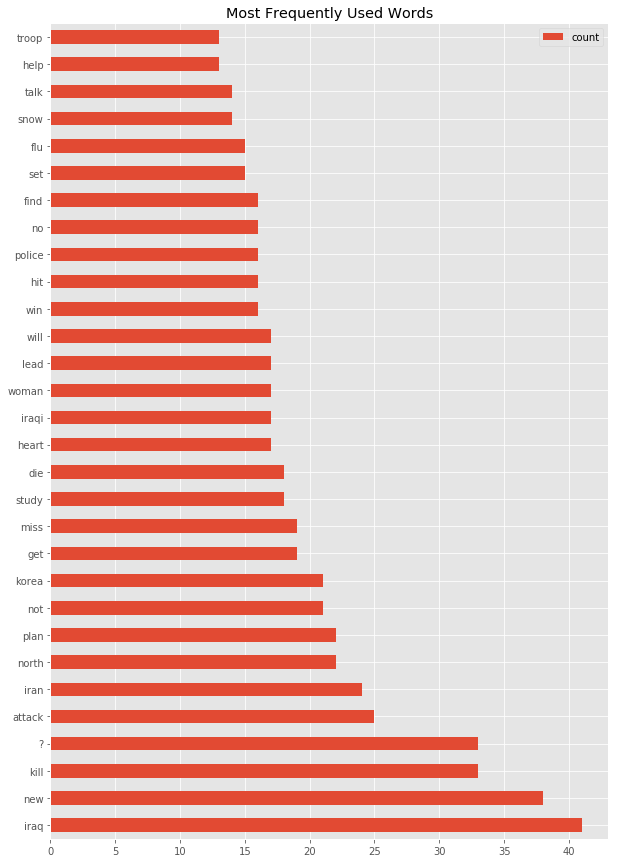

In [37]:
# plot the 30 most used words in the corpus
word_count_df[:30].plot(kind='barh', figsize=(10,15))
labels = [i for i in word_count_df[:30]['word']]
plt.yticks(ticks = range(30), labels = labels)
plt.title("Most Frequently Used Words")


### Corpus Top Bigrams

In [38]:
bigram_count_dict = {}

bigrams_set = set()
for row in corpus_df['text']:
    for bigram in list(bigrams(row.split())):
        bigrams_set.add(bigram)
        
        
for bigram in bigrams_set:
    bigram_count_dict[bigram]=0
    
for row in corpus_df['text']:
    for bigram in list(bigrams(row.split())):
        bigram_count_dict[bigram]+=1
        
# make a df of bigram counts        
bigram_count_df = pd.DataFrame({"bigram": [key for key in bigram_count_dict.keys()], "count": [val for val in bigram_count_dict.values()]})
bigram_count_df.sort_values('count', ascending=False, inplace=True)

Text(0.5, 1.0, 'Most Frequently Used Bigrams')

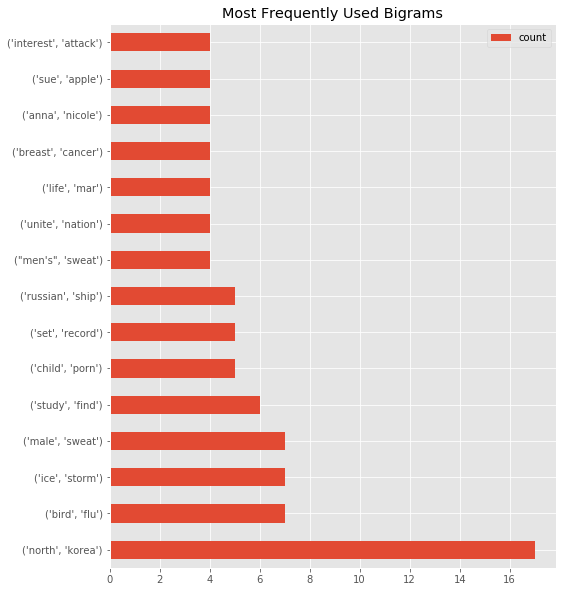

In [39]:
bigram_count_df[:15].plot(kind='barh', figsize=(8,10))
labels = [i for i in bigram_count_df[:15]['bigram']]
plt.yticks(ticks = range(15), labels = labels)
plt.title("Most Frequently Used Bigrams")

### Top Words Per Max Emotion Label

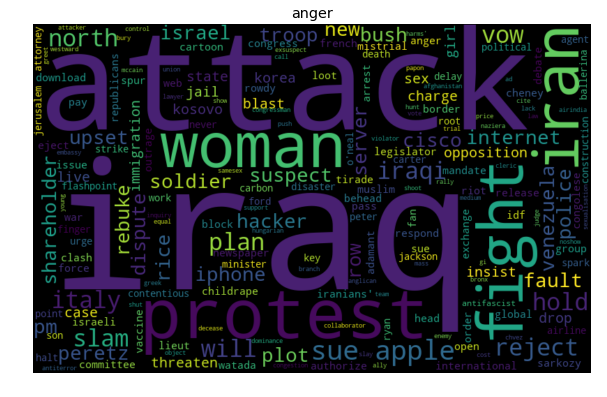

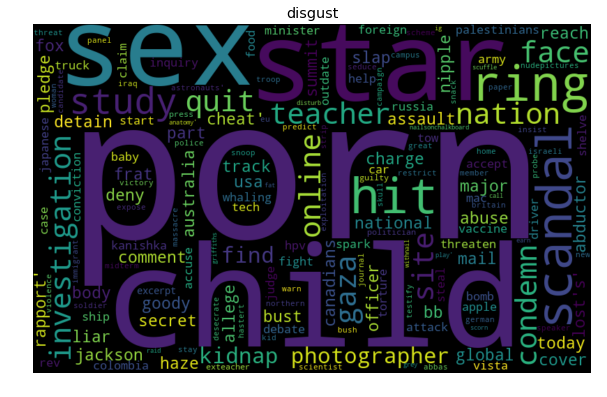

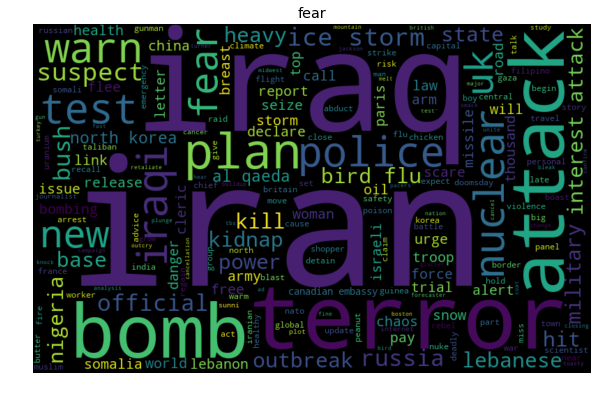

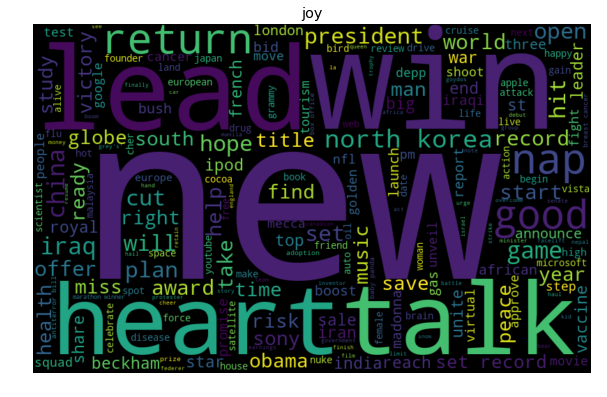

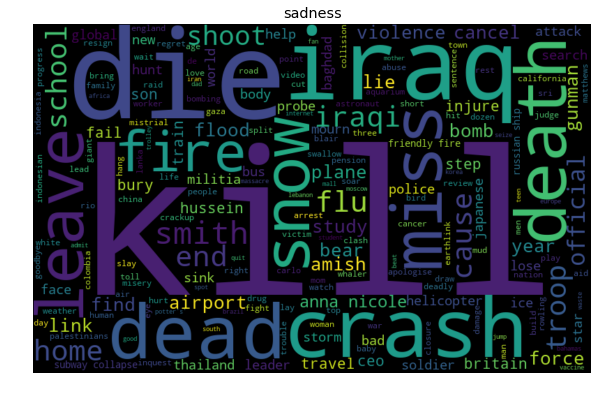

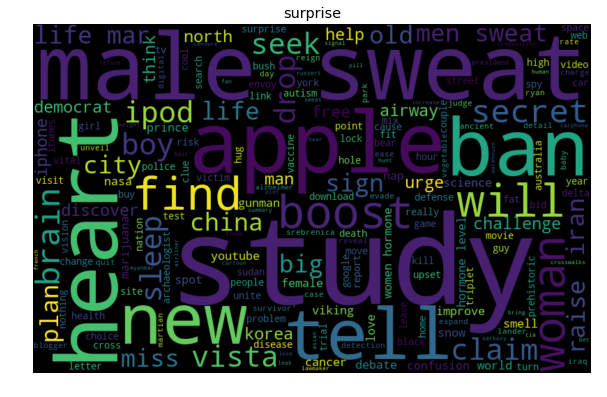

In [40]:
for i in list(emotion_df.columns[0:6]):
    
    indexes = []
    for index, val in enumerate(emotion_df['max']):
        if val==i:
            indexes.append(index)
    
    single_emotion = corpus_df['text'][indexes] 
    word_string = ' '.join([str(i) for i in single_emotion])

    wordcloud = WordCloud(width=800, height=500, random_state=42).generate(word_string)
    plt.figure(figsize=(10, 7))
    plt.title(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


### Top Words Per Valence Label

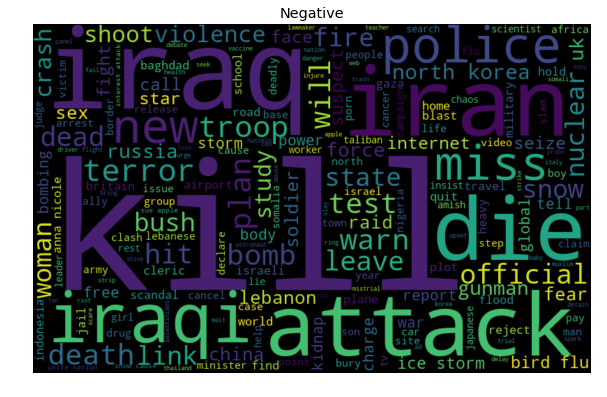

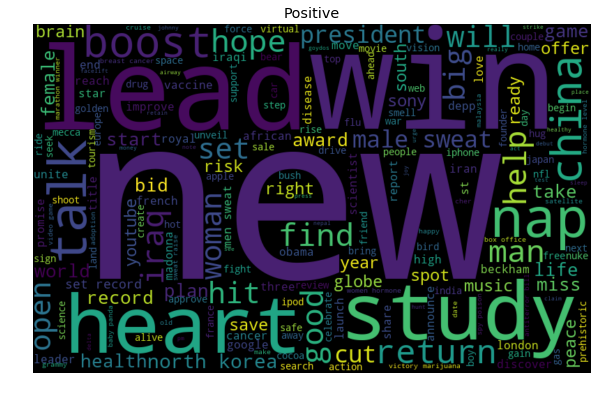

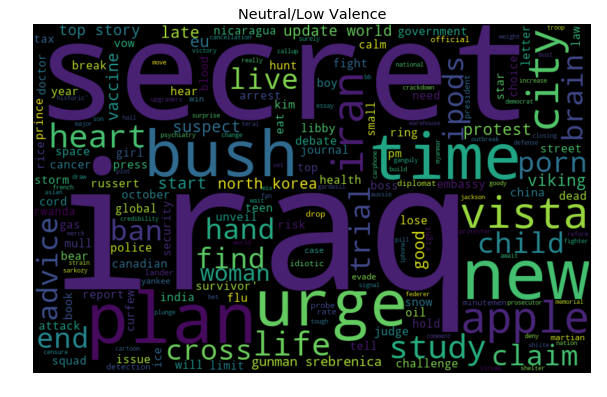

In [41]:
for i in [0,1,2]:
    
    indexes = []
    for index, val in enumerate(valence_df['label']):
        if val==i:
            indexes.append(index)
    
    single_valence = corpus_df['text'][indexes] 
    word_string = ' '.join([str(i) for i in single_valence])

    wordcloud = WordCloud(width=800, height=500, random_state=42).generate(word_string)
    plt.figure(figsize=(10, 7))
    
    if i==0:
        plt.title("Negative")
    elif i==1:
        plt.title("Positive")
    else:
        plt.title("Neutral/Low Valence")
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()